# 시계열 데이터 준비

In [2]:
## import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
import sklearn
import statsmodels
import warnings
import numpy as np
warnings.filterwarnings('ignore')

dataset_filepath = './ex4/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

print(ts)


Date
2015-09-30    102600.0
2015-10-01    109200.0
2015-10-02    110000.0
2015-10-05    108600.0
2015-10-06    111200.0
                ...   
2022-09-26    204500.0
2022-09-27    204500.0
2022-09-28    200500.0
2022-09-29    196500.0
2022-09-30    195000.0
Name: Close, Length: 1719, dtype: float64


# 각종 전처리 수행

In [3]:
ts = ts.interpolate(method='time')
ts[ts.isna()] 

ts_log = np.log(ts)

# 시계열 안정성 분석

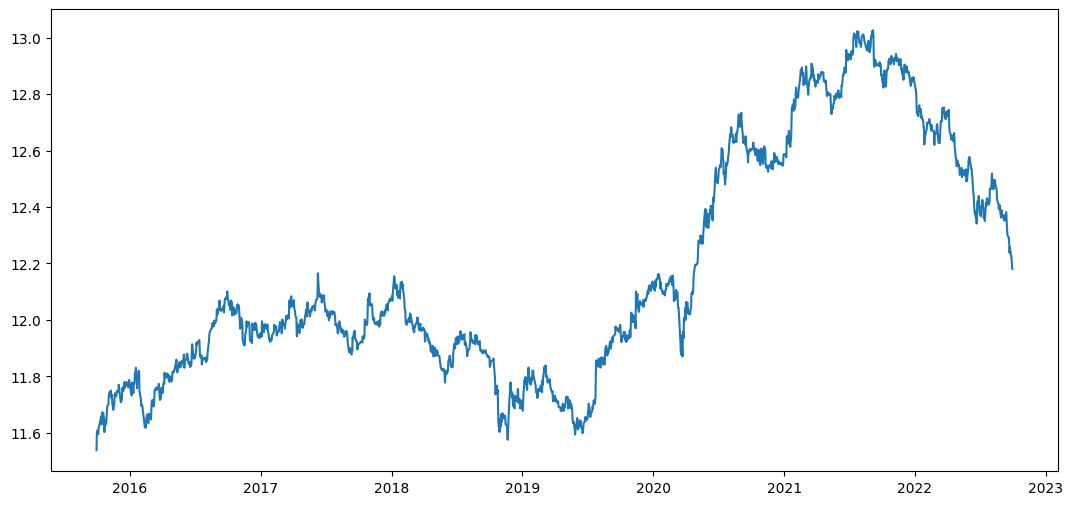

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6 
plt.plot(ts_log)

# 정성적 그래프 분석

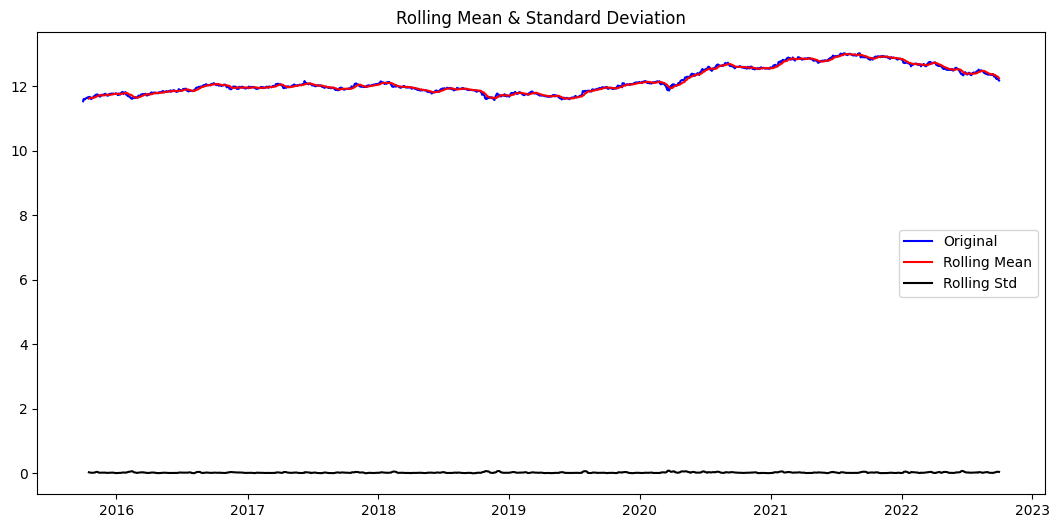

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.497152
p-value                           0.534920
#Lags Used                        1.000000
Number of Observations Used    1717.000000
Critical Value (1%)              -3.434164
Critical Value (5%)              -2.863225
Critical Value (10%)             -2.567667
dtype: float64


p 값이 너무크다 이건 쓰면 안되겟다

# Make it Stationary!

### 먼저 trend 를 제거해보자

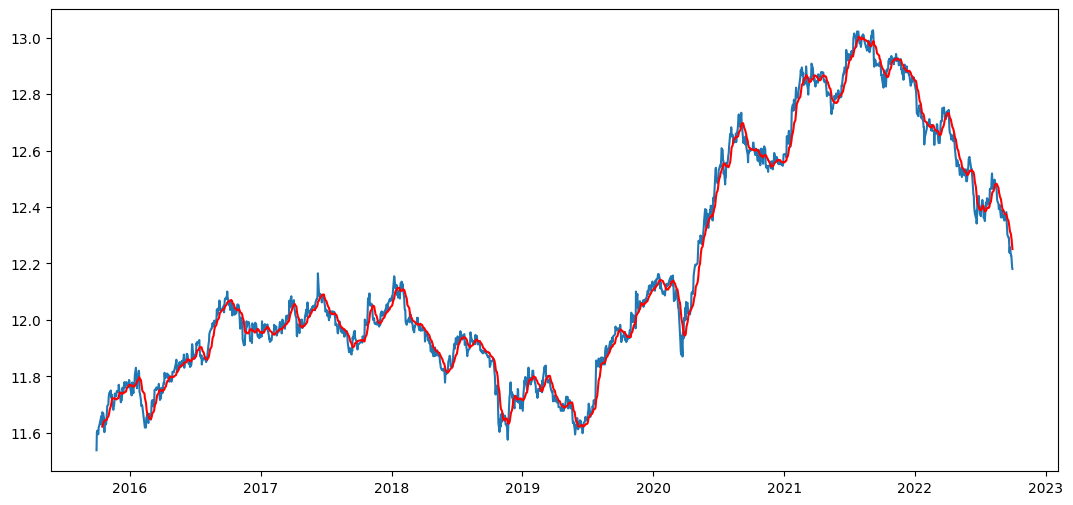

In [8]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')


In [9]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2015-09-30         NaN
2015-10-01         NaN
2015-10-02         NaN
2015-10-05         NaN
2015-10-06         NaN
2015-10-07         NaN
2015-10-08         NaN
2015-10-12         NaN
2015-10-13         NaN
2015-10-14         NaN
2015-10-15         NaN
2015-10-16    0.050932
2015-10-19    0.035006
2015-10-20    0.019933
2015-10-21    0.011025
Name: Close, dtype: float64

In [10]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2015-10-16    0.050932
2015-10-19    0.035006
2015-10-20    0.019933
2015-10-21    0.011025
2015-10-22   -0.039508
2015-10-23    0.001214
2015-10-26   -0.015269
2015-10-27   -0.012161
2015-10-28    0.010193
2015-10-29    0.034007
2015-10-30    0.041978
2015-11-02    0.042129
2015-11-03    0.063894
2015-11-04    0.069351
2015-11-05    0.067086
Name: Close, dtype: float64

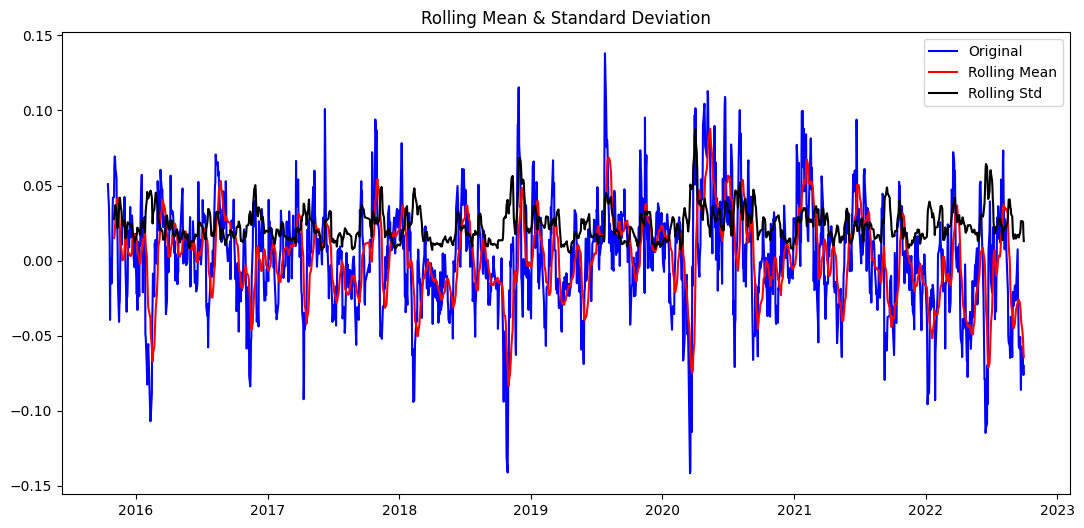

In [11]:
plot_rolling_statistics(ts_log_moving_avg)

In [12]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -1.169951e+01
p-value                        1.581069e-21
#Lags Used                     3.000000e+00
Number of Observations Used    1.704000e+03
Critical Value (1%)           -3.434193e+00
Critical Value (5%)           -2.863238e+00
Critical Value (10%)          -2.567674e+00
dtype: float64


# Differencing 해보자

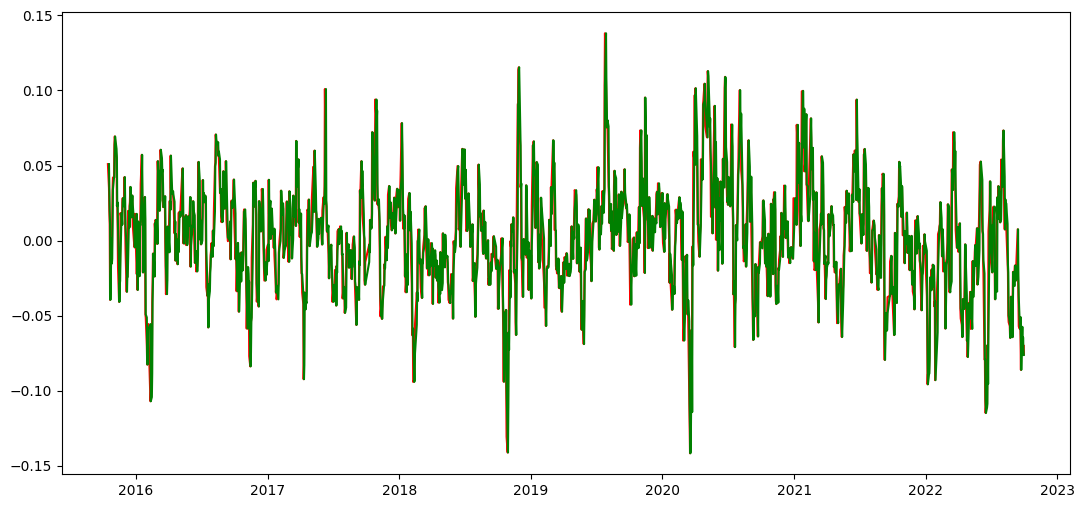

In [13]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='red')
plt.plot(ts_log_moving_avg_shift, color='green')

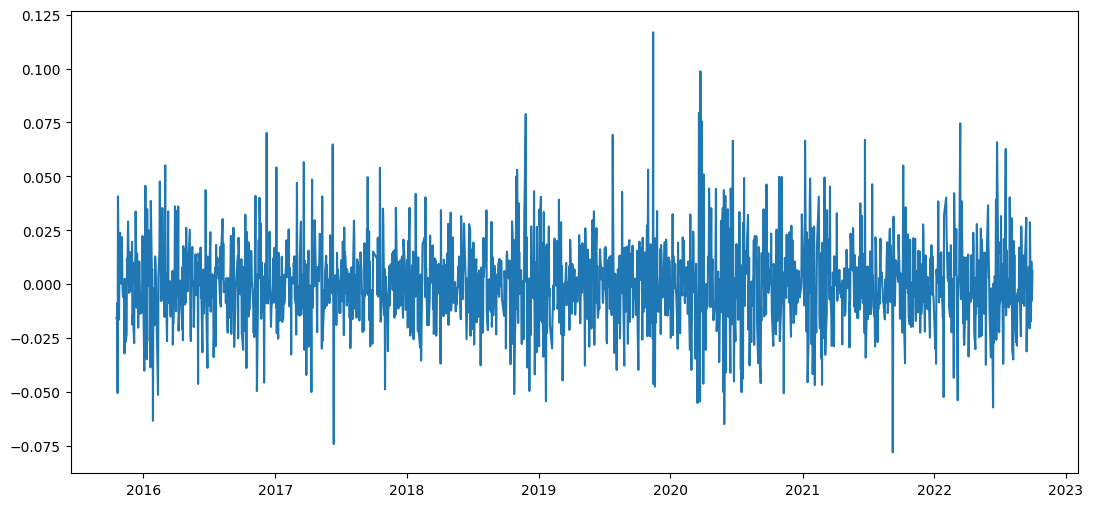

In [14]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

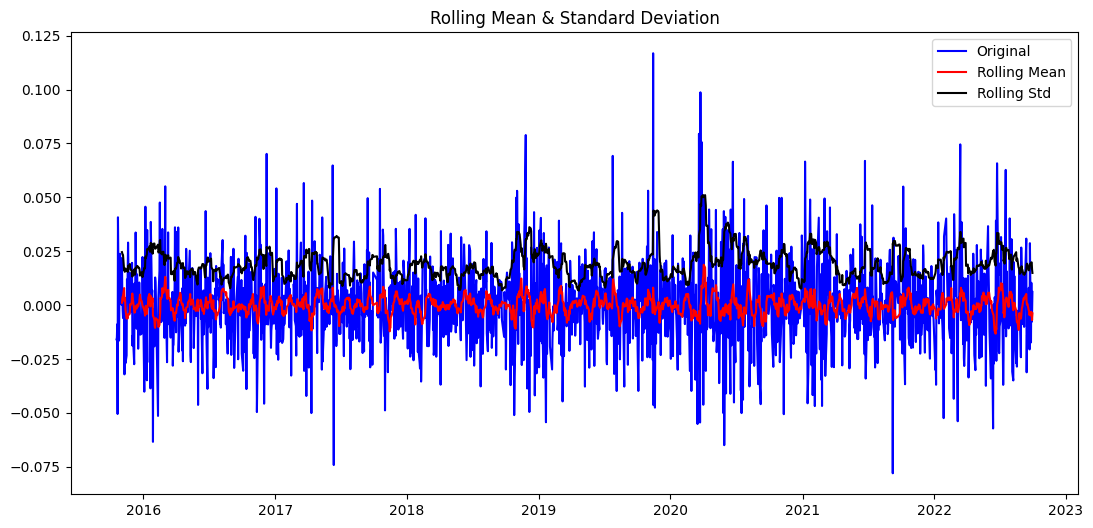

In [15]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [23]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.322487e+01
p-value                        9.848269e-25
#Lags Used                     2.000000e+01
Number of Observations Used    1.686000e+03
Critical Value (1%)           -3.434235e+00
Critical Value (5%)           -2.863256e+00
Critical Value (10%)          -2.567683e+00
dtype: float64


p값 낮췃다!

# 시계열 분해

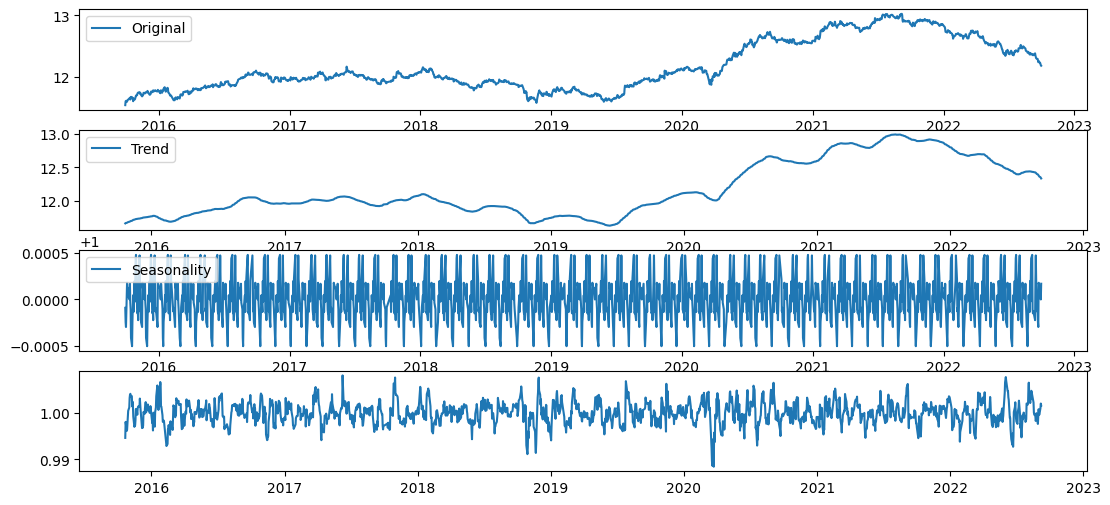

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')

In [17]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.163233e+01
p-value                        2.247046e-21
#Lags Used                     2.000000e+01
Number of Observations Used    1.668000e+03
Critical Value (1%)           -3.434276e+00
Critical Value (5%)           -2.863274e+00
Critical Value (10%)          -2.567693e+00
dtype: float64


# 학습, 테스트 데이터셋 분리

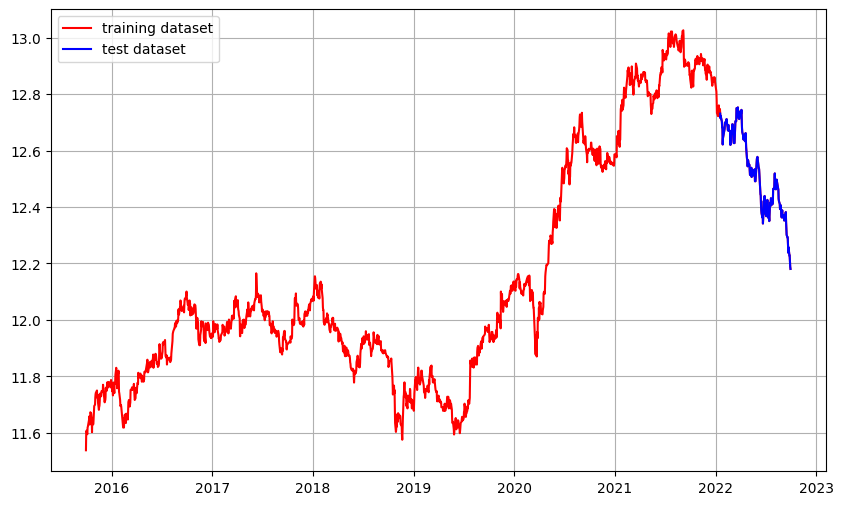

In [18]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 적정 ARIMA 모수 찾기

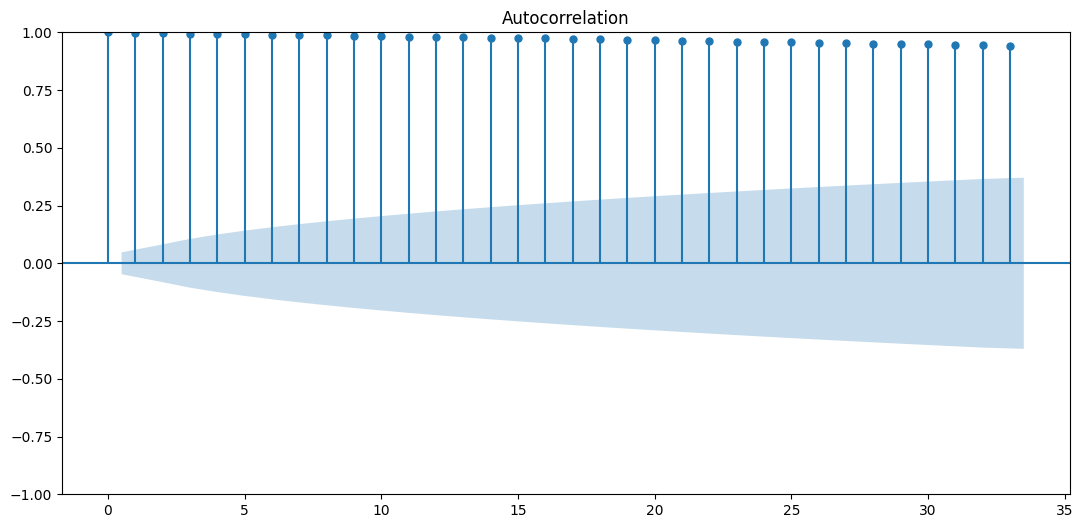

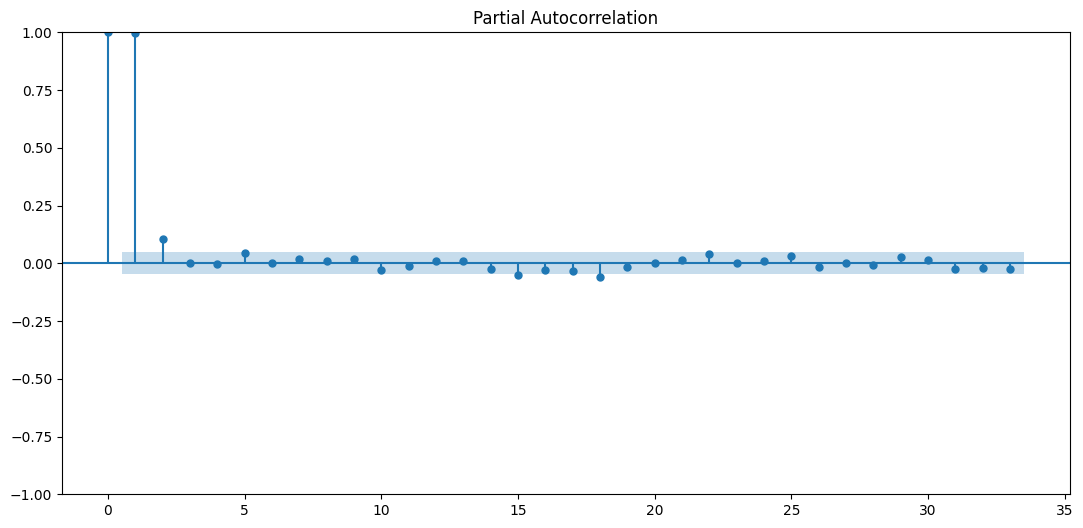

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

# p * q = 0 이랫으니까, pacf 에서 p를 1로 설정하자. acf에서의 q값은 의미없는듯


Results of Dickey-Fuller Test:
Test Statistic                  -44.279413
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1717.000000
Critical Value (1%)              -3.434164
Critical Value (5%)              -2.863225
Critical Value (10%)             -2.567667
dtype: float64


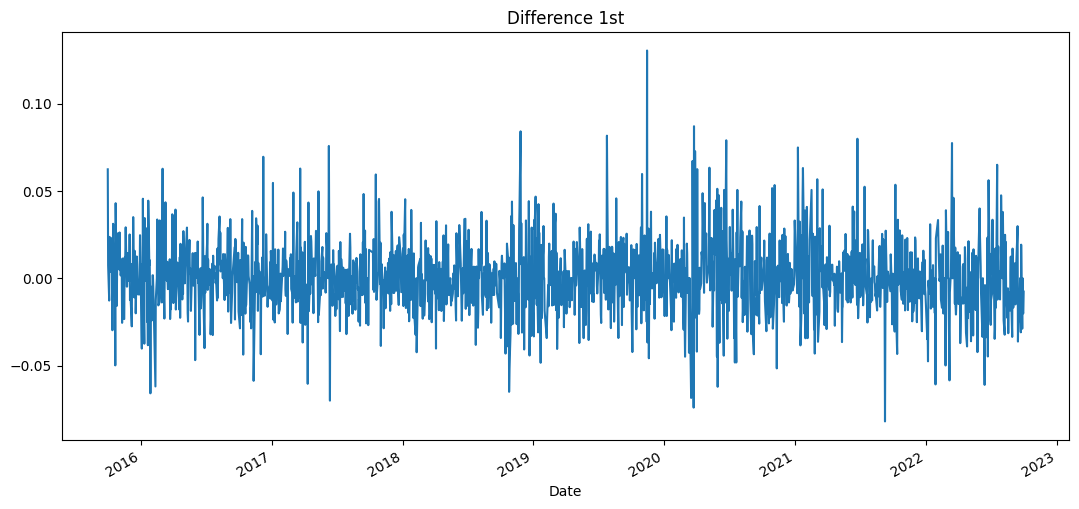

In [20]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -1.367184e+01
p-value                        1.454711e-25
#Lags Used                     2.500000e+01
Number of Observations Used    1.691000e+03
Critical Value (1%)           -3.434223e+00
Critical Value (5%)           -2.863251e+00
Critical Value (10%)          -2.567681e+00
dtype: float64


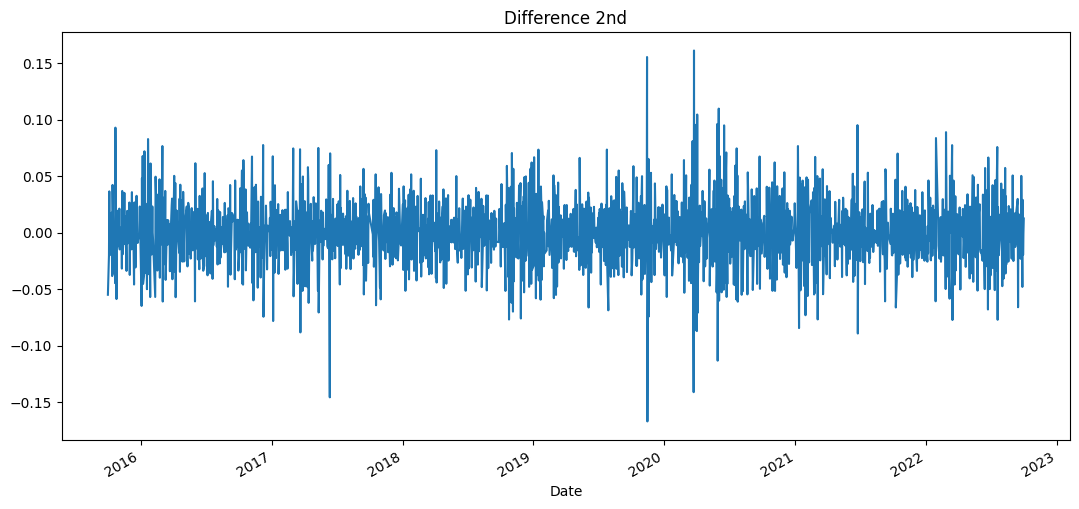

In [21]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 1차 차분과 2차 차분결과에서의 p-value 값을보면 1차차분때가 더 낮은데,  예측 결과 값에서는 2차차분으로 설정했을 때가 더 좋게 나왔습니다. 이점이 좀 의문..

# ARIMA 모델 훈련과 테스트

In [22]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1,2,0))
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1547
Model:                 ARIMA(1, 2, 0)   Log Likelihood                3488.892
Date:                Fri, 30 Sep 2022   AIC                          -6973.784
Time:                        17:59:14   BIC                          -6963.098
Sample:                             0   HQIC                         -6969.809
                               - 1547                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5449      0.017    -32.537      0.000      -0.578      -0.512
sigma2         0.0006   1.74e-05     36.670      0.000       0.001       0.001
Ljung-Box (L1) (Q):                  48.33   Jarque-

C:\Users\mk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\mk\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


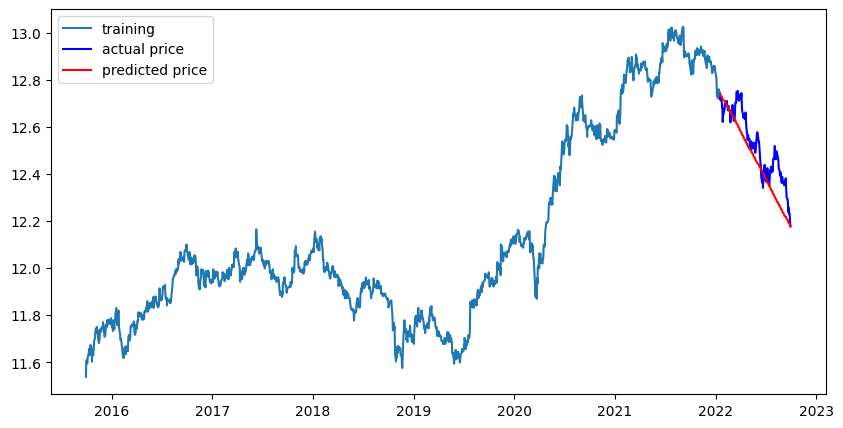

In [23]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  594529905.4899647
MAE:  19352.38754735751
RMSE:  24382.983933267165
MAPE: 7.00%
